In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [21]:
model_name = "LSTM_into_LSTM"

be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

# Important: order written is order in arrays 
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
input_jetkeys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r']
input_otherkeys = ['lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']

output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']

phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


output_length = len(output_keys)
input_length = len(input_keys)
 

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [22]:
crop0 =  100000
features_peroutput = 3
num_outputs = 3 
num_jets = 6

In [23]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]

def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*20
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*20
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*20
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*20
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 

def final_maxmean(array):
    means = np.mean(array, axis=0)
    array = array - means
    maxs = np.max(np.abs(array), axis=0)
    maxs = maxs + (maxs==0.0)*1
    array = array/maxs
    maxmean = np.stack([maxs, means], axis=1)
    return array, maxmean 

def inverse_final_maxmean(array, maxmean0):
    return array*maxmean0[:,0] + maxmean0[:,1]

def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return final_maxmean(arrays)

def invscale_arrays(keys, arrays, maxmean_dict, maxmean0):
    arrays = inverse_final_maxmean(arrays, maxmean0)
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

def create_mask():
    exist = jet_existence_dict()
    mask = [exist[list(exist.keys())[i]] for i in range(num_jets)] 
    samples_jets = np.stack(mask,axis=1)
    samples_jets = samples_jets.reshape((samples_jets.shape[0], samples_jets.shape[1], 1))
    return np.repeat(samples_jets, 5, axis=2) # 5 feature mask
    
    

In [73]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input, TI_maxmean0 = scale_arrays(input_keys, maxmean)

total_output, T0_maxmean0 = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, T0_maxmean0)

split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

# Split into jets and other input 
total_input_jets, total_input_other = total_input[:, 0:len(input_jetkeys)], total_input[:, len(input_jetkeys):]

# Reshape jets to be of shape (samples, num_jets, features per jet)
total_input_jets = np.split(total_input_jets, num_jets, axis=1)
total_input_jets = np.stack(total_input_jets, axis=1) 

# Mask the non-existent jets with value=-1
mask = create_mask()
total_input_jets = total_input_jets*mask + (1-mask)*(-1) 


# Split into training and validation data 
train_input_jets, test_input_jets = total_input_jets[0:split, :, :], total_input_jets[split:, :, :]
train_input_other, test_input_other = total_input_other[0:split, :], total_input_other[split:, :]

# Shape the output data into timesteps 
total_output = np.split(total_output, num_outputs, axis=1)
total_output = np.stack(total_output, axis=1)
train_output, test_output = total_output[0:split, :], total_output[split:, :]

# Reshape the "other" input for a single timestep LSTM 
train_input_other = train_input_other.reshape(train_input_other.shape[0], 1, train_input_other.shape[1])
test_input_other = test_input_other.reshape(test_input_other.shape[0], 1, test_input_other.shape[1])

print(train_input_jets.shape, train_input_other.shape)
print(test_input_jets.shape, test_input_other.shape)
print(train_output.shape, test_output.shape)

(80000, 6, 5) (80000, 1, 5)
(20000, 6, 5) (20000, 1, 5)
(80000, 3, 3) (20000, 3, 3)


In [74]:
# For this version, don't split into jets/other

train_input = np.concatenate([train_input_jets,train_input_other],axis=1)
test_input = np.concatenate([test_input_jets, test_input_other], axis=1)


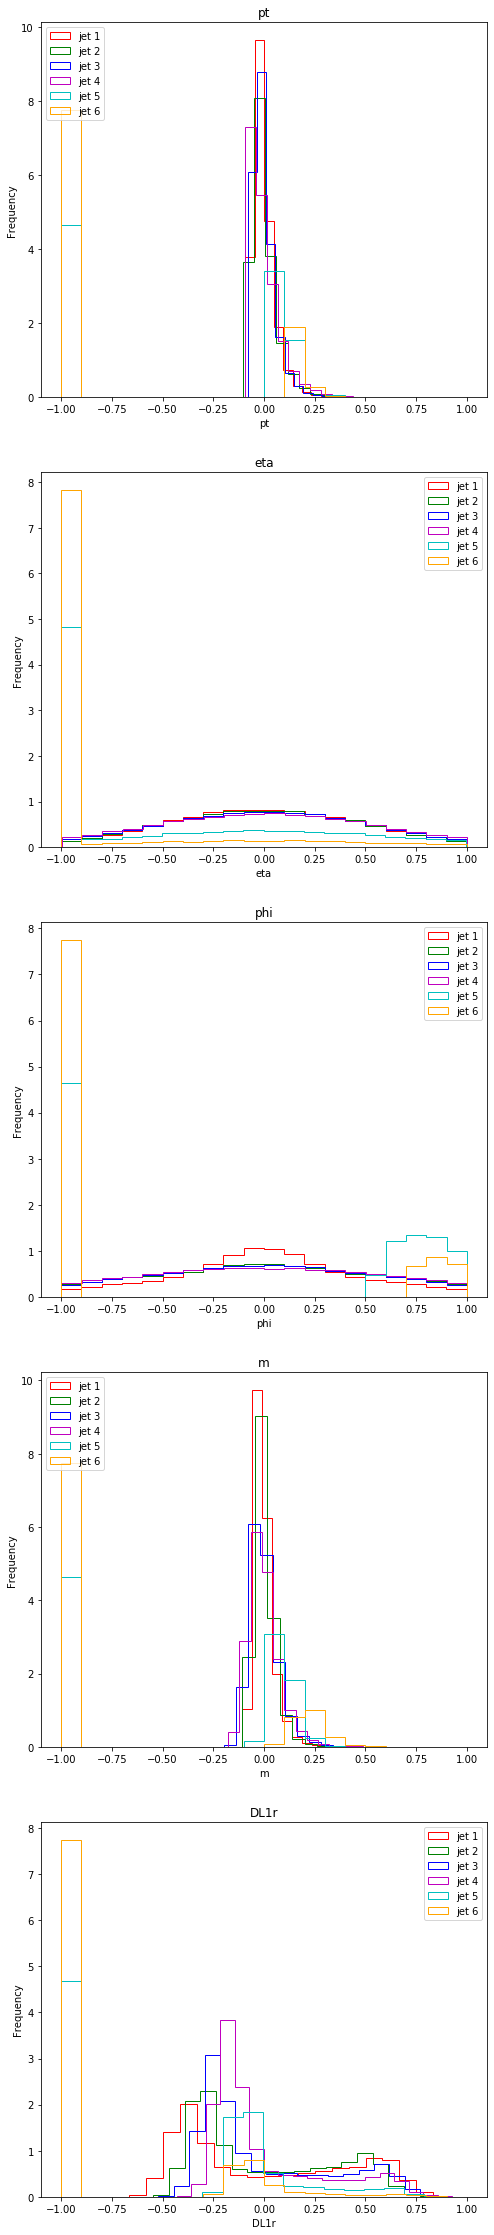

In [26]:
def plot_input_jets():
    features_perjet = 5
    features = ['pt', 'eta', 'phi', 'm', 'DL1r']
    colours = ['r', 'g', 'b', 'm', 'c', 'orange', 'purple', 'k']
    plt.figure(figsize=(8, 8*features_perjet))
    for i in range(features_perjet):
        plt.subplot(features_perjet, 1, i+1)
        plt.xlabel(features[i])
        plt.title(features[i])
        plt.ylabel('Frequency')
        for j in range(num_jets):
            plt.hist(train_input_jets[:,j,i], 20, 
                     histtype='step', color=colours[j], 
                     density=True, label='jet ' + str(j+1))
        plt.legend()
        
if True: 
    plot_input_jets()

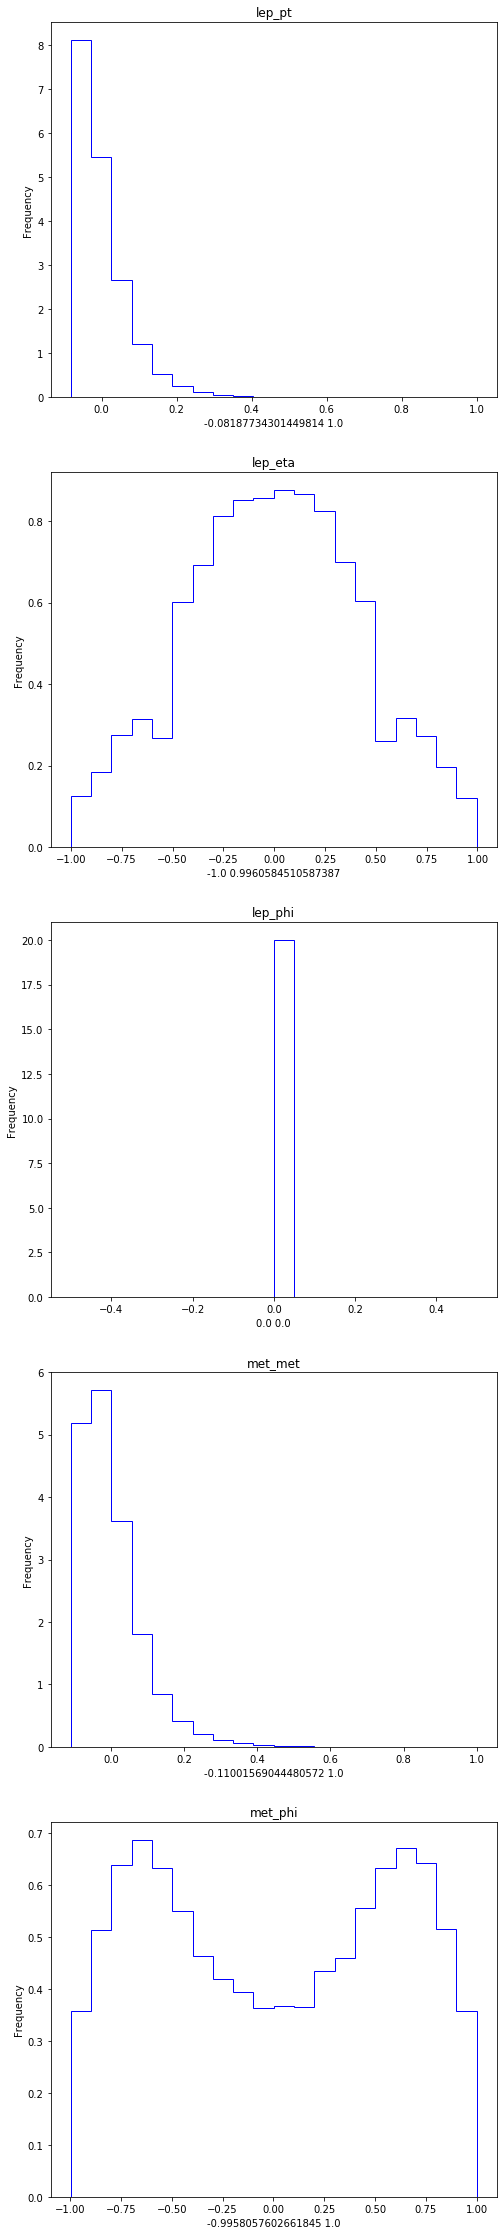

In [27]:
def plot_input_other():
    num_plots = train_input_other.shape[2]
    plt.figure(figsize=(8, 8*num_plots))
    for i in range(num_plots):
        plt.subplot(num_plots, 1, i+1)
        var = train_input_other[:,:, i]
        plt.xlabel("{} {}".format(np.min(var), np.max(var)))
        plt.title(input_otherkeys[i])
        plt.ylabel('Frequency')
        plt.hist(var, 20, histtype='step', color='b', density=True)
        
if True:
    plot_input_other()

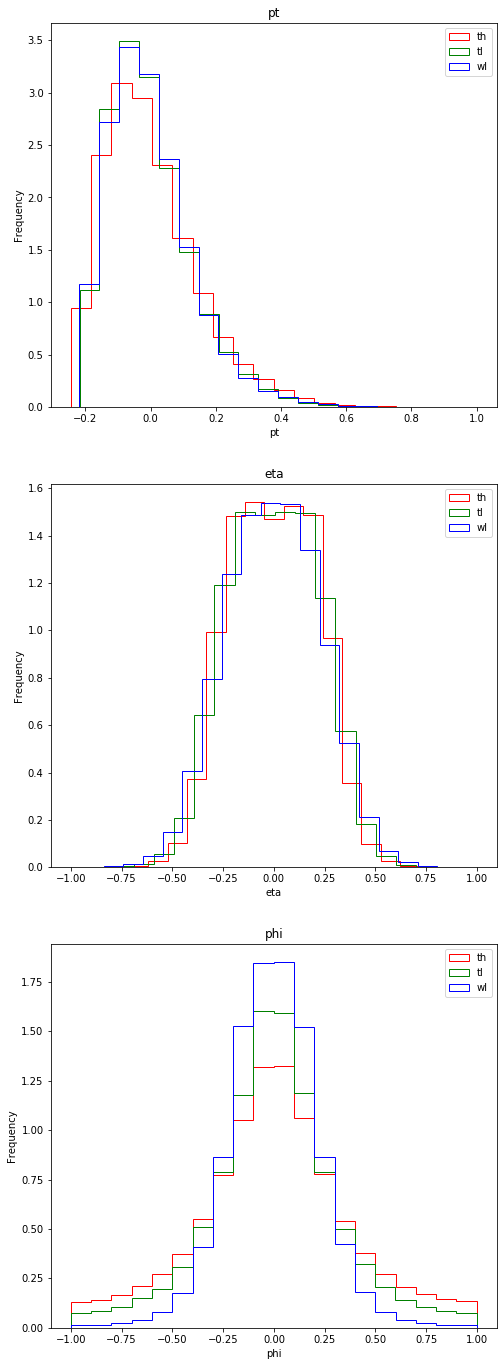

In [28]:
def plot_outputs():
    
    num_plots = features_peroutput
    features = ['pt', 'eta', 'phi', 'm', 'DL1r']
    colours = ['r', 'g', 'b', 'm', 'c', 'orange', 'purple', 'k']
    output_vars = ['th', 'tl','wl']
    plt.figure(figsize=(8, 8*num_plots))
    for i in range(features_peroutput):
        plt.subplot(features_peroutput, 1, i+1)
        plt.xlabel(features[i])
        plt.title(features[i])
        plt.ylabel('Frequency')
        for j in range(num_outputs):
            plt.hist(total_output[:,j,i], 20, 
                     histtype='step', color=colours[j],
                     density=True, label=output_vars[j])
        plt.legend()
        
if True:
    plot_outputs()

In [46]:
# Build model

def build_model():
    jet_input = layers.Input(shape=(num_jets+1, 5))
    masking = layers.Masking(mask_value=-1)(jet_input)
    LSTM0 = layers.LSTM(64, return_sequences=False)(masking)
    LSTM1 = layers.RepeatVector(num_outputs)(LSTM0)
    LSTM2 = layers.LSTM(features_peroutput, return_sequences=True)(LSTM1)
    
    model = keras.models.Model(inputs=[jet_input], outputs=LSTM2)
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 


model = build_model()
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 7, 5)]            0         
_________________________________________________________________
masking_23 (Masking)         (None, 7, 5)              0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 64)                17920     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 64)             0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 3, 3)              816       
Total params: 18,736
Trainable params: 18,736
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Fit model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
Epochs= 1024
tf.config.experimental_run_functions_eagerly(True) # I don't know what this does but it fixes one of my errors 

history = model.fit([train_input] , train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=True, callbacks=[callback],
                   batch_size=512)


Epoch 1/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0544 - mse: 0.0544 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 2/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 3/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 4/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 5/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 6/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 7/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 8/1024
125/125 [==============================] -

125/125 [==============================] - 3s 25ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 62/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 63/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 64/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 65/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 66/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 67/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 68/1024
125/125 [==============================] - 3s 25

125/125 [==============================] - 3s 25ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 122/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 123/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 124/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 125/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 126/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 127/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 128/1024
125/125 [==============================] 

Epoch 181/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 182/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 183/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 184/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 185/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 186/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 187/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 188/1024
125/125 [=================

Epoch 241/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 242/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 243/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 244/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 245/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 246/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 247/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 248/1024
125/125 [=================

Epoch 301/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 302/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 303/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 304/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 305/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 306/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 307/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 308/1024
125/125 [=================

Epoch 361/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 362/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 363/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 364/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 365/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 366/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 367/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 368/1024
125/125 [=================

Epoch 421/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 422/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 423/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 424/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 425/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 426/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 427/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 428/1024
125/125 [=================

Epoch 481/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 482/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 483/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 484/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 485/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 486/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 487/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 488/1024
125/125 [=================

Epoch 541/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 542/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 543/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 544/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 545/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 546/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 547/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 548/1024
125/125 [=================

Epoch 601/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 602/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 603/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 604/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 605/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 606/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 607/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 608/1024
125/125 [=================

Epoch 661/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 662/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 663/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 664/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 665/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 666/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 667/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 668/1024
125/125 [=================

Epoch 721/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 722/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 723/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 724/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 725/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 726/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 727/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 728/1024
125/125 [=================

Epoch 781/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 782/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 783/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 784/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 785/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 786/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 787/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 788/1024
125/125 [=================

Epoch 841/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 842/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 843/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 844/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 845/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 846/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 847/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 848/1024
125/125 [=================

Epoch 901/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 902/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 903/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 904/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 905/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 906/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 907/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 908/1024
125/125 [=================

Epoch 961/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 962/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 963/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 964/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 965/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 966/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 967/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 968/1024
125/125 [=================

125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 1021/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 1022/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 1023/1024
125/125 [==============================] - 3s 25ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 1024/1024
125/125 [==============================] - 3s 24ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0351 - val_mse: 0.0351


In [48]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: LSTM_into_LSTM/assets


Text(0.5, 1.0, 'MSE loss')

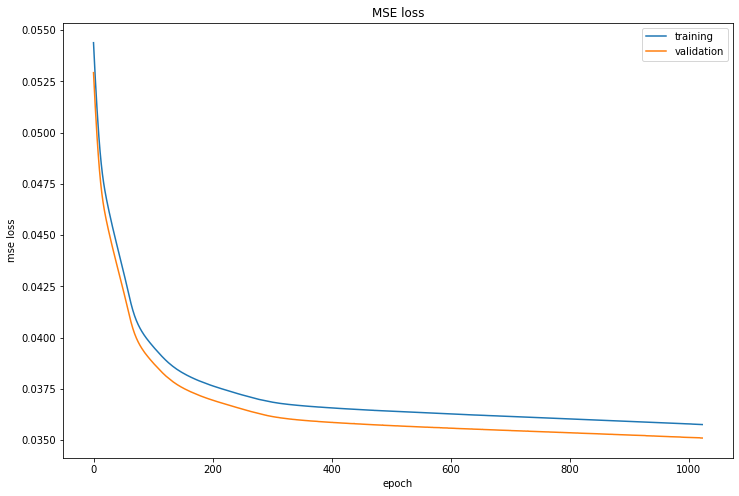

In [49]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [85]:
predictions = model.predict(test_input)
predictions = np.split(predictions, num_outputs, axis=1)
predictions = [predictions[i].reshape((predictions[i].shape[0], predictions[i].shape[-1])) for i in range(len(predictions))]
predictions = np.concatenate(predictions, axis=1)

test_output0 = np.split(test_output, 3, axis=1)
test_output0 = [test_output0[i].reshape((test_output0[i].shape[0], test_output0[i].shape[-1])) for i in range(len(test_output0))]
test_output0 = np.concatenate(test_output0, axis=1)

In [86]:
print(predictions.shape, test_output0.shape)

(20000, 9) (20000, 9)


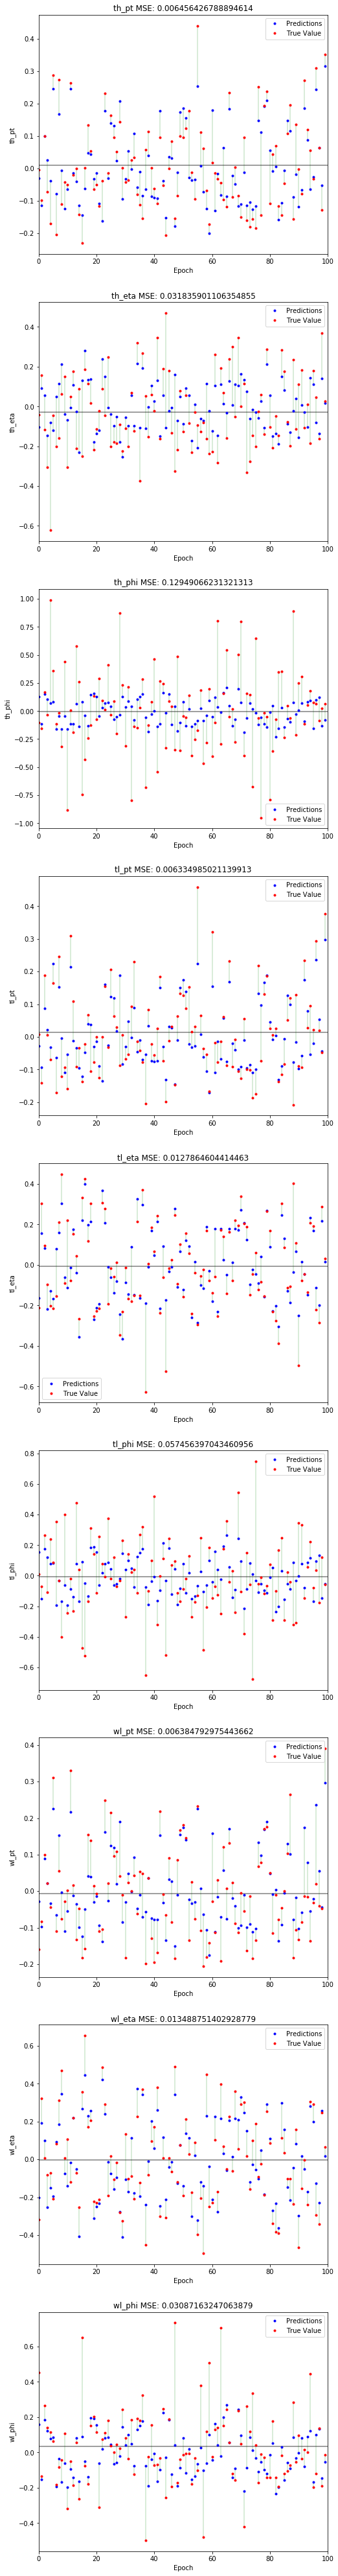

In [87]:


# Training 
crop = 100 

train_small = predictions[0:100,:]
output_small = test_output0[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [88]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output0[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output0)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output0[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.035809946649284094
th_pt MSE :  0.0083596552
th_eta MSE :  0.0325322363
th_phi MSE :  0.1255164351
tl_pt MSE :  0.0053123539
tl_eta MSE :  0.0111868256
tl_phi MSE :  0.0848497189
wl_pt MSE :  0.0063644595
wl_eta MSE :  0.0124570901
wl_phi MSE :  0.0357107450


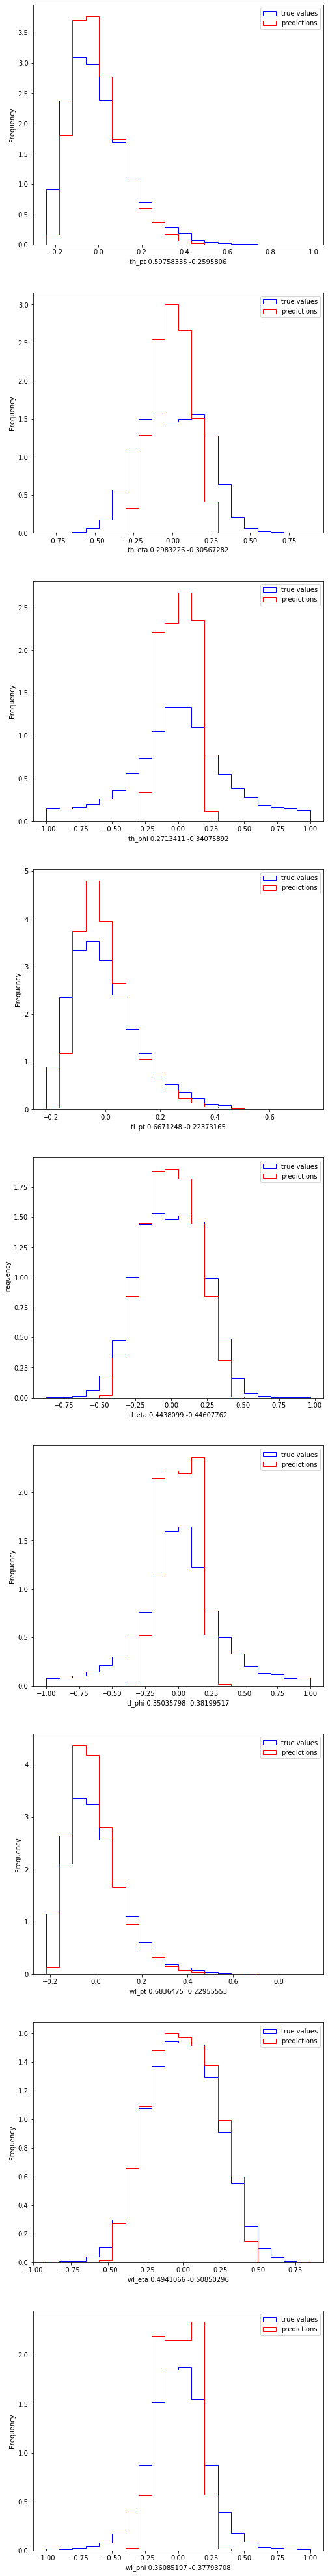

In [90]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output0[:, i], bins=20)
    plt.hist(test_output0[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
total_output, maxmean0 = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, maxmean0)[split:,:]

total_predictions = model.predict(np.append(train_input, test_input, axis=0))
total_predictions = np.split(total_predictions, num_outputs, axis=1)
total_predictions = [total_predictions[i].reshape((total_predictions[i].shape[0], total_predictions[i].shape[-1])) for i in range(len(total_predictions))]
total_predictions = np.concatenate(total_predictions, axis=1)

predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean, maxmean0)[split:,:]


In [ ]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

In [ ]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')